In [2]:
# Load essential libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Scikit-learn libraries for modeling and evaluation
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, roc_auc_score

# Display settings
pd.set_option('display.max_columns', None)
sns.set(style='whitegrid')
import warnings
warnings.filterwarnings("ignore")


In [3]:
# For local Colab file upload
from google.colab import files
uploaded = files.upload()

# Then load the CSV
import pandas as pd

df = pd.read_csv("train_u6lujuX_CVtuZ9i.csv")
print("Data loaded. Shape:", df.shape)
df.head()


Saving train_u6lujuX_CVtuZ9i.csv to train_u6lujuX_CVtuZ9i.csv
Data loaded. Shape: (614, 13)


,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y


In [4]:
# Basic structure and data types
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Loan_ID            614 non-null    object 
 1   Gender             601 non-null    object 
 2   Married            611 non-null    object 
 3   Dependents         599 non-null    object 
 4   Education          614 non-null    object 
 5   Self_Employed      582 non-null    object 
 6   ApplicantIncome    614 non-null    int64  
 7   CoapplicantIncome  614 non-null    float64
 8   LoanAmount         592 non-null    float64
 9   Loan_Amount_Term   600 non-null    float64
 10  Credit_History     564 non-null    float64
 11  Property_Area      614 non-null    object 
 12  Loan_Status        614 non-null    object 
dtypes: float64(4), int64(1), object(8)
memory usage: 62.5+ KB


In [5]:
# Check for missing values in each column
missing = df.isnull().sum()
missing = missing[missing > 0].sort_values(ascending=False)
missing

,0
Credit_History,50
Self_Employed,32
LoanAmount,22
Dependents,15
Loan_Amount_Term,14
Gender,13
Married,3


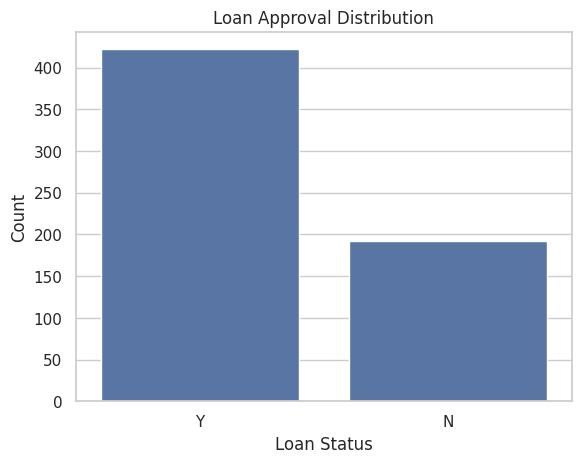

,proportion
Loan_Status,
Y,0.687296
N,0.312704


In [6]:
# Check balance of the target class
sns.countplot(data=df, x='Loan_Status')
plt.title('Loan Approval Distribution')
plt.xlabel("Loan Status")
plt.ylabel("Count")
plt.show()

# Show value counts as numbers
df['Loan_Status'].value_counts(normalize=True)

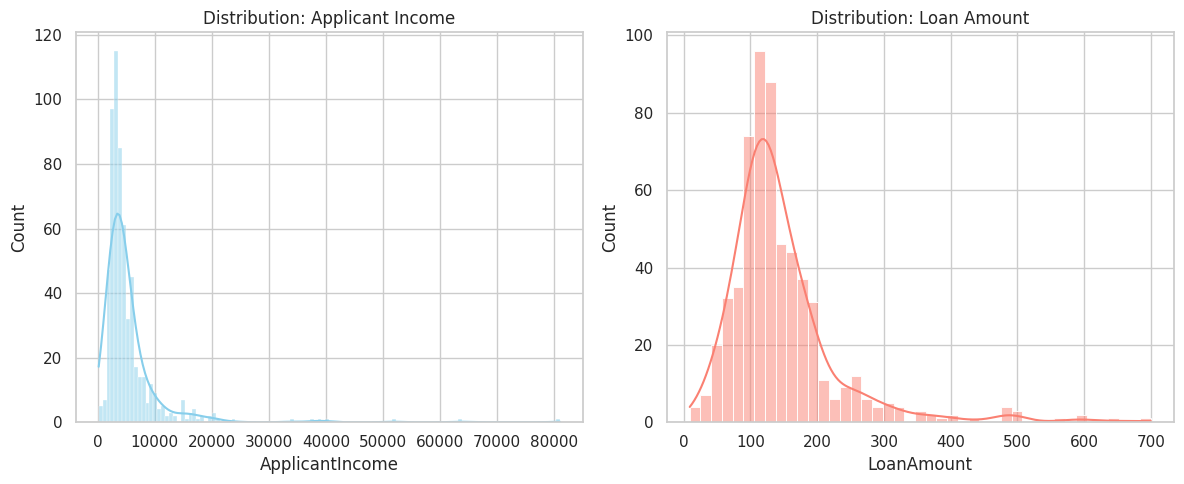

In [7]:
#  Histogram of Applicant Income and Loan Amount
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

sns.histplot(df['ApplicantIncome'], kde=True, ax=axes[0], color='skyblue')
axes[0].set_title("Distribution: Applicant Income")

sns.histplot(df['LoanAmount'], kde=True, ax=axes[1], color='salmon')
axes[1].set_title("Distribution: Loan Amount")

plt.tight_layout()
plt.show()

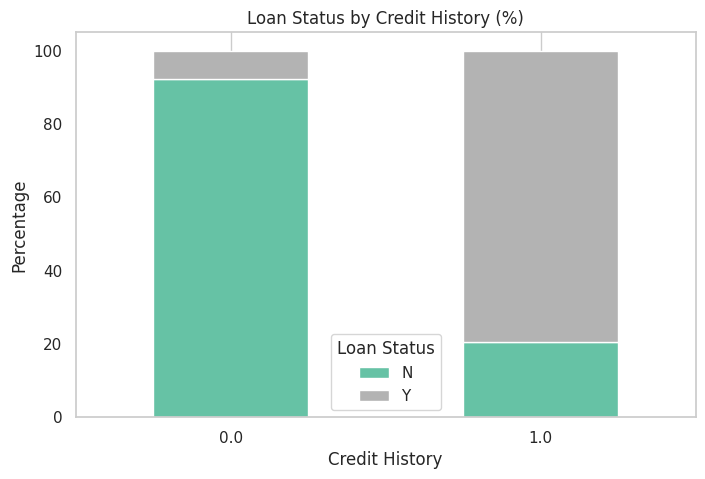

In [8]:
#STEP Loan status by credit history
credit_plot = pd.crosstab(df['Credit_History'], df['Loan_Status'], normalize='index') * 100
credit_plot.plot(kind='bar', stacked=True, figsize=(8,5), colormap='Set2')

plt.title('Loan Status by Credit History (%)')
plt.ylabel('Percentage')
plt.xlabel('Credit History')
plt.legend(title='Loan Status')
plt.xticks(rotation=0)
plt.grid(axis='y')
plt.show()


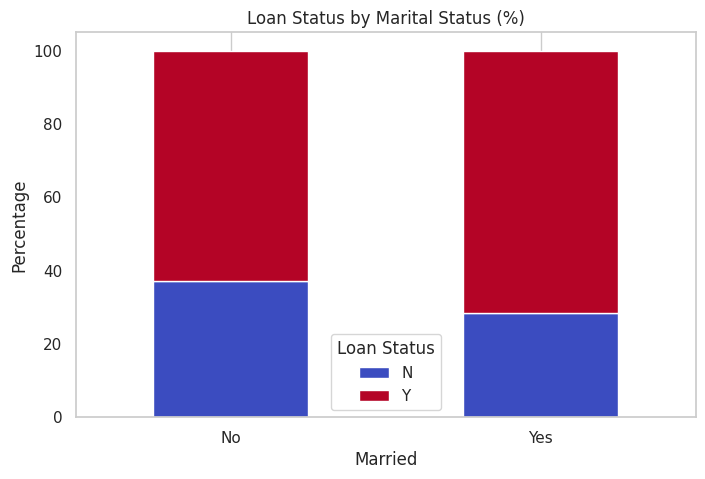

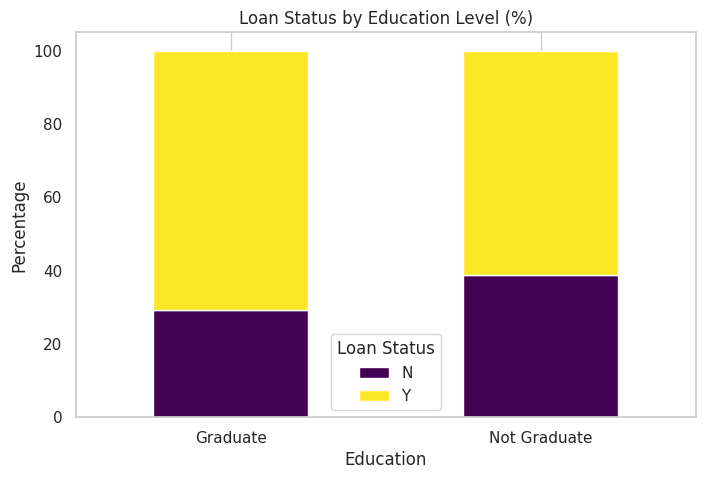

In [9]:
# Married vs Loan Approval
married_plot = pd.crosstab(df['Married'], df['Loan_Status'], normalize='index') * 100
married_plot.plot(kind='bar', stacked=True, figsize=(8,5), colormap='coolwarm')

plt.title('Loan Status by Marital Status (%)')
plt.ylabel('Percentage')
plt.xlabel('Married')
plt.legend(title='Loan Status')
plt.xticks(rotation=0)
plt.grid(axis='y')
plt.show()

# Education vs Loan Approval
edu_plot = pd.crosstab(df['Education'], df['Loan_Status'], normalize='index') * 100
edu_plot.plot(kind='bar', stacked=True, figsize=(8,5), colormap='viridis')

plt.title('Loan Status by Education Level (%)')
plt.ylabel('Percentage')
plt.xlabel('Education')
plt.legend(title='Loan Status')
plt.xticks(rotation=0)
plt.grid(axis='y')
plt.show()

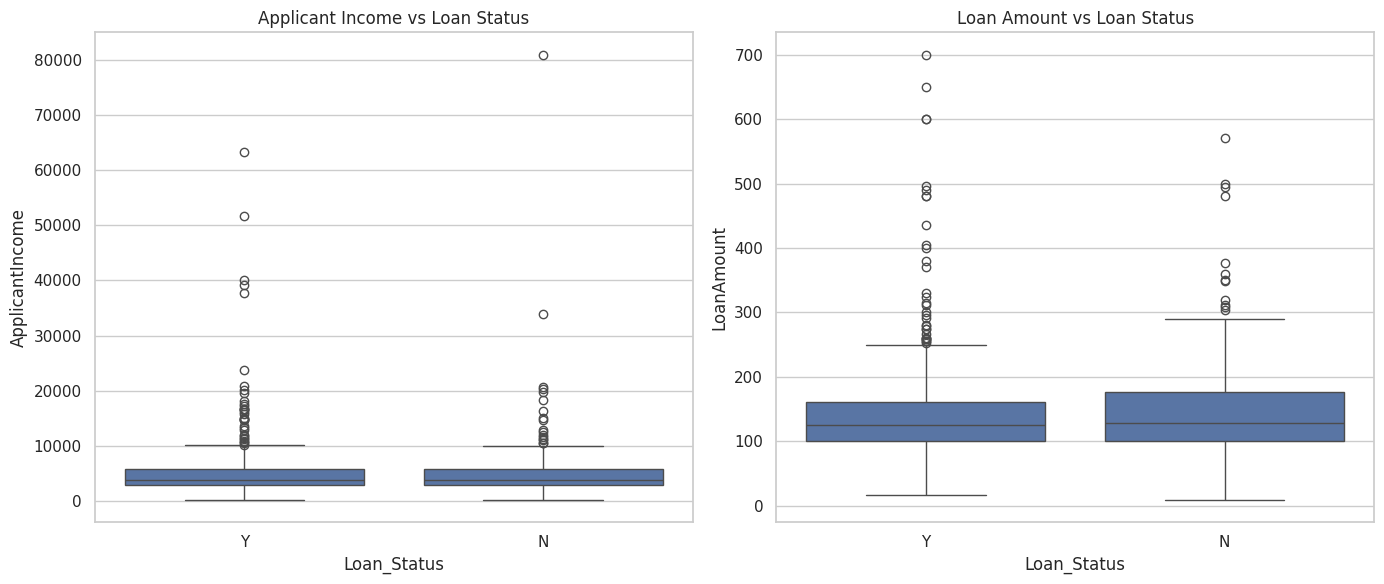

In [10]:
# Income and Loan Amount by approval status
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

sns.boxplot(x='Loan_Status', y='ApplicantIncome', data=df, ax=axes[0])
axes[0].set_title('Applicant Income vs Loan Status')

sns.boxplot(x='Loan_Status', y='LoanAmount', data=df, ax=axes[1])
axes[1].set_title('Loan Amount vs Loan Status')

plt.tight_layout()
plt.show()

In [11]:
##Impute missing values

# Numerical features: use median or mode based on skewness
df['LoanAmount'].fillna(df['LoanAmount'].median(), inplace=True)
df['Loan_Amount_Term'].fillna(df['Loan_Amount_Term'].mode()[0], inplace=True)
df['Credit_History'].fillna(df['Credit_History'].mode()[0], inplace=True)

# Categorical features: fill with most frequent (mode)
categorical_columns = ['Gender', 'Married', 'Dependents', 'Self_Employed']
for col in categorical_columns:
    df[col].fillna(df[col].mode()[0], inplace=True)


In [12]:
#Feature Engineering

# Total income of applicant and co-applicant
df['Total_Income'] = df['ApplicantIncome'] + df['CoapplicantIncome']

# EMI = LoanAmount / Loan_Amount_Term
df['EMI'] = df['LoanAmount'] / df['Loan_Amount_Term']

# Balance income after paying EMI (in '000s)
df['Balance_Income'] = df['Total_Income'] - (df['EMI'] * 1000)

In [13]:
#Drop ID column (non-predictive)
df.drop('Loan_ID', axis=1, inplace=True)

In [15]:
#Encode categorical variables using Label Encoding
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
cat_cols = df.select_dtypes(include='object').columns

for col in cat_cols:
    df[col] = le.fit_transform(df[col])

In [20]:
#Split data into features and target
X = df.drop('Loan_Status', axis=1)
y = df['Loan_Status']

print("✅ Features shape:", X.shape)
print("✅ Target shape:", y.shape)

✅ Features shape: (614, 14)
✅ Target shape: (614,)


In [21]:
#Train-Test Split (70/30)
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

print("✅ X_train:", X_train.shape)
print("✅ X_test:", X_test.shape)
print("✅ y_train distribution:\n", y_train.value_counts(normalize=True))


✅ X_train: (429, 14)
✅ X_test: (185, 14)
✅ y_train distribution:
 Loan_Status
1    0.687646
0    0.312354
Name: proportion, dtype: float64


In [22]:
#Logistic Regression
lr_model = LogisticRegression()
lr_model.fit(X_train, y_train)

# Predict on test set
y_pred_lr = lr_model.predict(X_test)

In [23]:
#Decision Tree Classifier
dt_model = DecisionTreeClassifier(max_depth=4, random_state=42)  # limit depth to avoid overfitting
dt_model.fit(X_train, y_train)

# Predict on test set
y_pred_dt = dt_model.predict(X_test)

In [24]:
#Evaluate both models
from sklearn.metrics import classification_report, confusion_matrix

print("📊 Logistic Regression Performance")
print(confusion_matrix(y_test, y_pred_lr))
print(classification_report(y_test, y_pred_lr))

print("\n📊 Decision Tree Performance")
print(confusion_matrix(y_test, y_pred_dt))
print(classification_report(y_test, y_pred_dt))

📊 Logistic Regression Performance
[[ 19  39]
 [  3 124]]
              precision    recall  f1-score   support

           0       0.86      0.33      0.47        58
           1       0.76      0.98      0.86       127

    accuracy                           0.77       185
   macro avg       0.81      0.65      0.67       185
weighted avg       0.79      0.77      0.74       185


📊 Decision Tree Performance
[[ 36  22]
 [  9 118]]
              precision    recall  f1-score   support

           0       0.80      0.62      0.70        58
           1       0.84      0.93      0.88       127

    accuracy                           0.83       185
   macro avg       0.82      0.77      0.79       185
weighted avg       0.83      0.83      0.83       185



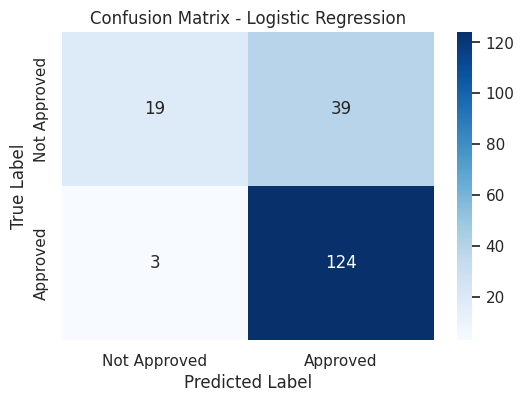

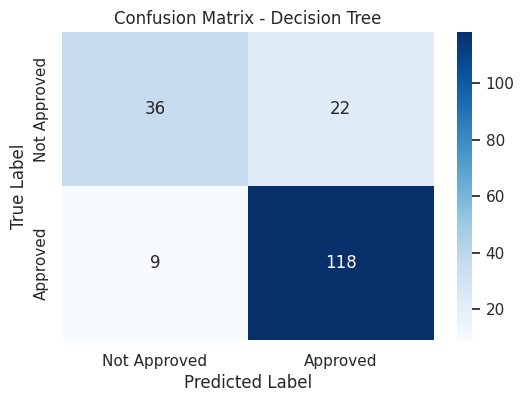

In [29]:
def plot_confusion_matrix(cm, model_name, classes=['Not Approved', 'Approved']):
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.title(f'Confusion Matrix - {model_name}')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

# Get confusion matrices
cm_lr = confusion_matrix(y_test, y_pred_lr)
cm_dt = confusion_matrix(y_test, y_pred_dt)

# Plot confusion matrices
plot_confusion_matrix(cm_lr, "Logistic Regression")
plot_confusion_matrix(cm_dt, "Decision Tree")

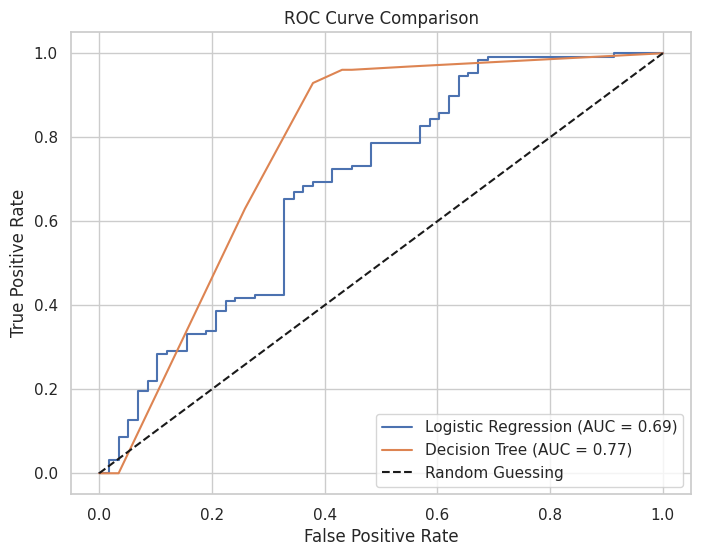

In [26]:
 #ROC Curve for both models
from sklearn.metrics import roc_curve, roc_auc_score

# Predict probabilities for ROC
lr_probs = lr_model.predict_proba(X_test)[:, 1]
dt_probs = dt_model.predict_proba(X_test)[:, 1]

# Get ROC curve points
fpr_lr, tpr_lr, _ = roc_curve(y_test, lr_probs)
fpr_dt, tpr_dt, _ = roc_curve(y_test, dt_probs)

# AUC scores
auc_lr = roc_auc_score(y_test, lr_probs)
auc_dt = roc_auc_score(y_test, dt_probs)

# Plotting
plt.figure(figsize=(8, 6))
plt.plot(fpr_lr, tpr_lr, label=f"Logistic Regression (AUC = {auc_lr:.2f})")
plt.plot(fpr_dt, tpr_dt, label=f"Decision Tree (AUC = {auc_dt:.2f})")
plt.plot([0, 1], [0, 1], 'k--', label='Random Guessing')

plt.title("ROC Curve Comparison")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid(True)
plt.show()

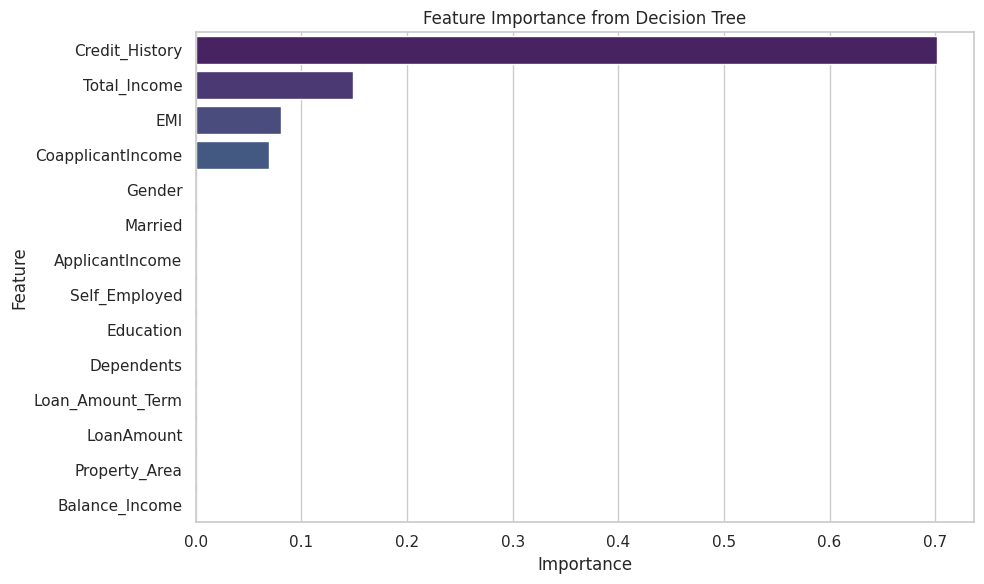

In [27]:
 #Plot Feature Importance (Decision Tree)
importances = dt_model.feature_importances_
feature_names = X.columns

# Create a DataFrame for easier plotting
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df, palette='viridis')
plt.title("Feature Importance from Decision Tree")
plt.tight_layout()
plt.show()